# Tutorial about simulating LocData

Locan provides methods for simulating basic localization data sets as LocData objects.

## Setting things up

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import locan as lc

In [2]:
lc.show_versions(system=False, dependencies=False, verbose=False)


Locan:
   version: 0.7.dev3+gb9aca40

Python:
   version: 3.8.8


## Simulate localization data that follows a homogeneous Poisson distribution in 2D

In [3]:
dat = lc.simulate_csr(n_samples=1000, feature_range=(0,1000), seed=1)

dat.print_summary()

identifier: "1"
comment: ""
creation_date: "2021-03-04 13:48:16 +0100"
modification_date: ""
source: SIMULATION
state: RAW
element_count: 1000
frame_count: 0
file_type: UNKNOWN_FILE_TYPE
file_path: ""



### Show scatter plots

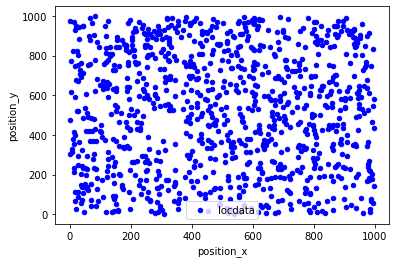

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1)
dat.data.plot.scatter(x='position_x', y='position_y', ax=ax, color='Blue', label='locdata')
plt.show()

## Simulate localization data that follows a homogeneous Poisson distribution in 3D

In [5]:
dat_3D = lc.simulate_csr(n_samples=1000, n_features=3, feature_range=(0,1000), seed=1)

dat_3D.print_summary()

identifier: "2"
comment: ""
creation_date: "2021-03-04 13:48:16 +0100"
modification_date: ""
source: SIMULATION
state: RAW
element_count: 1000
frame_count: 0
file_type: UNKNOWN_FILE_TYPE
file_path: ""



### Show scatter plots

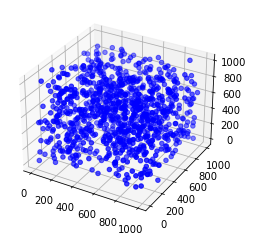

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x,y,z = dat_3D.coordinates.T
ax.scatter(x, y, z, color='Blue', label='locdata')
plt.show()

## Simulate localization data that follows a homogeneous Poisson distribution on disc

In [7]:
dat = lc.simulate_csr_on_disc(n_samples=1000, radius=2, seed=1)

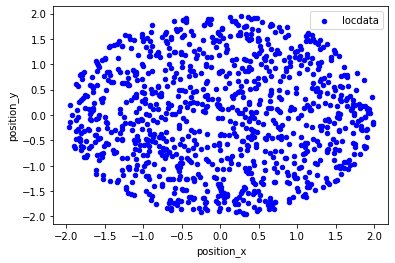

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1)
dat.data.plot.scatter(x='position_x', y='position_y', ax=ax, color='Blue', label='locdata')
plt.show()

## Simulate localization data that follows a homogeneous Poisson distribution on other regions

In [9]:
region = lc.RoiRegion(region_type='polygon', region_specs=((0, 0), (0, 5), (4, 3), (2, 0.5), (0, 0)))
dat = lc.simulate_csr_on_region(region, n_samples=1000, seed=1)

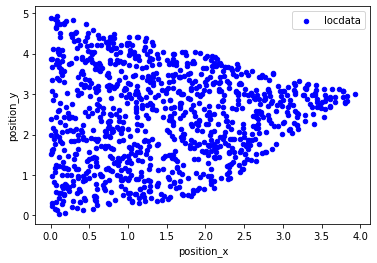

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1)
dat.data.plot.scatter(x='position_x', y='position_y', ax=ax, color='Blue', label='locdata')
plt.show()

## Simulate localization data that follows a Neyman-Scott (Matern) distribution in 2D

In a Matern process localizations are distributed homogeneously in circles of a given radius.

In [11]:
dat = lc.simulate_Matern(n_samples=1000, n_features=2, centers=10, radius=50, feature_range=(0, 1000), seed=1)

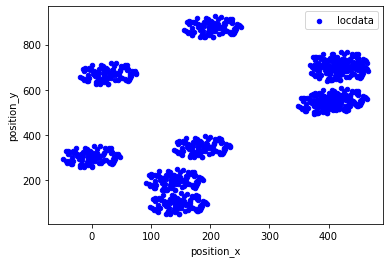

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1)
dat.data.plot.scatter(x='position_x', y='position_y', ax=ax, color='Blue', label='locdata')
plt.show()

## Simulate localization data that follows a Neyman-Scott (Thomas) distribution in 2D

In a Thomas process localizations are distributed in clusters where each cluster shows a Gauss distribution with center and specified standard deviation.

In [13]:
dat = lc.simulate_Thomas(n_samples=1000, n_features=2, centers=10, feature_range=(0, 1000), cluster_std=20, seed=1)

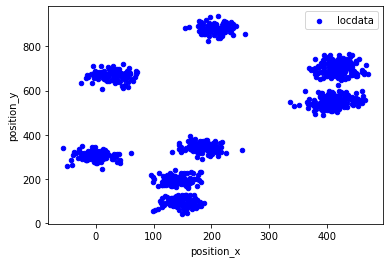

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)
dat.data.plot.scatter(x='position_x', y='position_y', ax=ax, color='Blue', label='locdata')
plt.show()

## Simulate localization data that follows a Neyman-Scott distribution in 3D

In [15]:
dat_3D = lc.simulate_Thomas(n_samples=1000, n_features=3, centers=10, feature_range=(0, 1000), cluster_std=10, seed=1)

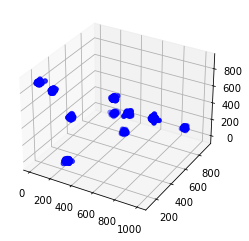

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x,y,z = dat_3D.coordinates.T
ax.scatter(x, y, z, color='Blue', label='locdata')
plt.show()

## Resample data

The resample function provides additional localizations for each given localizations that are Gauss distributed around the original localizations with a standard deviation given by the `uncertainty_x` property. 

In [17]:
n = 10
dat = lc.simulate_Thomas(n_samples=n, n_features=2, centers=10, feature_range=(0, 1000), cluster_std=10, seed=1)
dat.dataframe = dat.dataframe.assign(uncertainty_x= 20*np.random.random(n))
dat.dataframe = dat.dataframe.assign(uncertainty_y= 20*np.random.random(n))

In [18]:
dat_resampled = lc.resample(dat, n_samples=10)

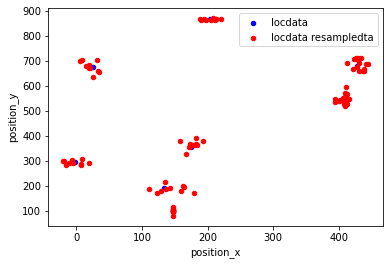

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1)
dat.data.plot.scatter(x='position_x', y='position_y', ax=ax, color='Blue', label='locdata')
dat_resampled.data.plot.scatter(x='position_x', y='position_y', ax=ax, color='Red', label='locdata resampledta')
plt.show()